In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing import image

In [167]:
# import the datasets
train_dir = "./dataset/train"
test_dir = "./dataset/test"

Emotions = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', "Surprised"]

In [168]:
# import hashlib
# import os
# from PIL import Image

# # Check for duplicates and remove
# def remove_duplicates(duplicates):
#     for duplicate, original in duplicates:
#         os.remove(duplicate)  # Remove the duplicate file

# def hash_image(image_path):
#     with Image.open(image_path) as img:
#         hash_value = hashlib.md5(img.tobytes()).hexdigest()
#     return hash_value

# def find_duplicates(directory):
#     hash_dict = {}
#     duplicates = []
#     for subdir, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(subdir, file)
#             file_hash = hash_image(file_path)
#             if file_hash in hash_dict:
#                 duplicates.append((file_path, hash_dict[file_hash]))
#             else:
#                 hash_dict[file_hash] = file_path
#     return duplicates

# duplicates = find_duplicates(train_dir)
# print(f"Found {len(duplicates)} duplicate images.")

# remove_duplicates(duplicates)

# train_dir = "./dataset/train"
# test_dir = "./dataset/test"

In [169]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split = 0.25,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.25)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48,48),
                                                    batch_size = 64,
                                                    shuffle  = True, 
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed=12)

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                        target_size = (48,48),
                                                        batch_size = 64,
                                                        shuffle  = False, 
                                                        color_mode = "grayscale",
                                                        class_mode = "categorical",
                                                        subset = "validation",
                                                        seed=12)

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (48,48),
                                                  batch_size = 64,
                                                  shuffle  = False, 
                                                  color_mode = "grayscale",
                                                  class_mode = "categorical",
                                                  seed=12)

Found 20606 images belonging to 7 classes.
Found 6867 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


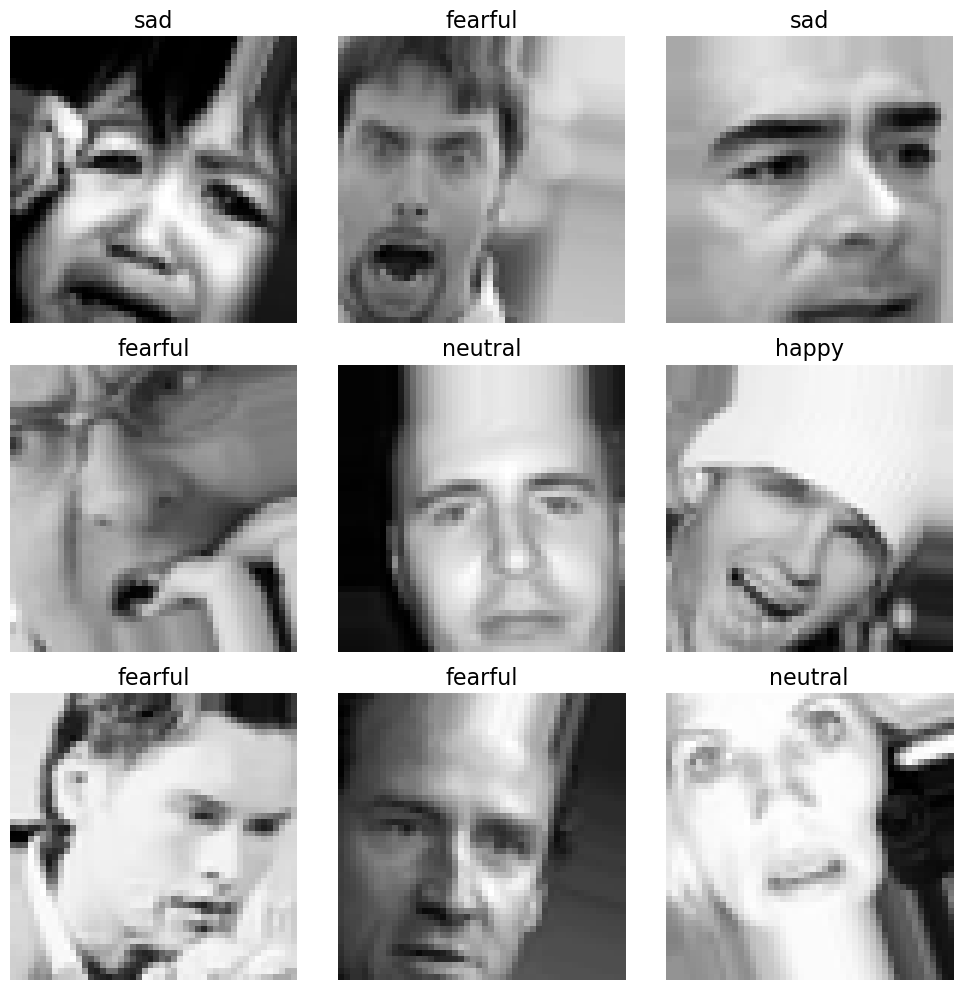

In [170]:
# Function to plot images
def display_images_with_labels(images, labels, class_labels):
    # Convert labels to class names
    class_indices = np.argmax(labels, axis=-1)  # Get class indices from one-hot labels
    titles = [class_labels[idx] for idx in class_indices]  # Convert indices to class names
    
    # Plot 9 images in a 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    for img, title, ax in zip(images[:9], titles[:9], axes):
        ax.imshow(img.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
        ax.set_title(title, fontsize=16)
        ax.axis('off')  # Hide axis
        
    plt.tight_layout()
    plt.show()

# Retrieve a batch of images and labels
images, labels = next(train_generator)

# Get class labels from train_generator
class_labels = list(train_generator.class_indices.keys())

# Display 9 images with labels
display_images_with_labels(images, labels, class_labels)

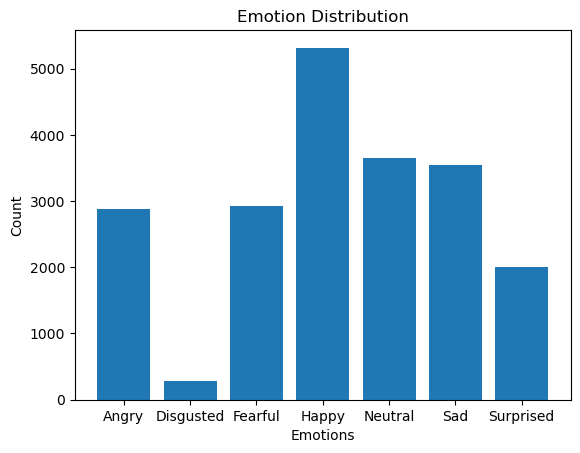

In [171]:
# class distribution
plt.bar(Emotions, [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)])
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.show()

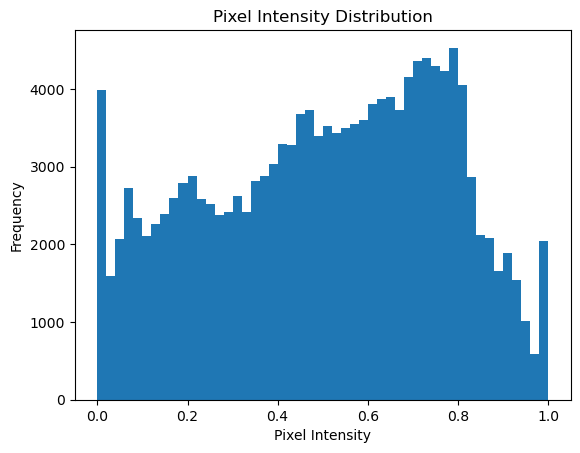

Mean pixel intensity: 0.5048268437385559
Standard deviation of pixel intensity: 0.262102872133255


In [172]:
image_flat = images.flatten()
plt.hist(image_flat, bins=50)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

mean = np.mean(images)
std_dev = np.std(images)

print(f'Mean pixel intensity: {mean}')
print(f'Standard deviation of pixel intensity: {std_dev}')

In [173]:
from sklearn.utils.class_weight import compute_class_weight

# balance the class distribution using weights
classes = np.unique(train_generator.classes)
y = train_generator.classes
class_weights = compute_class_weight('balanced', classes=classes, y=y)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

class_weights_gen = {0: 1.0, 1: 5.0, 2: 1.0, 3: 0.6, 4: 0.8, 5: 0.8, 6: 1.0}

{0: 1.0196447127517443, 1: 10.292707292707293, 2: 1.005366900858704, 3: 0.5538502889396586, 4: 0.8062761669992565, 5: 0.8322630154691223, 6: 1.4703867561010417}


In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

# build CNN model
model = Sequential()

model.add(Conv2D(32,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Piper\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (Activation)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (Activation)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_74 (Activation)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_75 (Activation)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_76 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 512)            │       524,80

 Total params: 1,187,463 (4.53 MB)

 Trainable params: 1,183,431 (4.51 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [175]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=5,
                                                        verbose=1,
                                                        restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

epochs = 30

history = model.fit(
    x=train_generator,
    epochs=epochs,
    class_weight = class_weights_gen,
    validation_data = validation_generator,
    callbacks= [earlyStoppingCallback, lr_schedule])

history = pd.DataFrame(history.history)

Epoch 1/30


c:\Users\Piper\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.1786 - loss: 2.9860 - val_accuracy: 0.2580 - val_loss: 2.6654 - learning_rate: 5.0000e-04
Epoch 2/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - accuracy: 0.2237 - loss: 2.5935 - val_accuracy: 0.2583 - val_loss: 2.4563 - learning_rate: 5.0000e-04
Epoch 3/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.2855 - loss: 2.3970 - val_accuracy: 0.2832 - val_loss: 2.4400 - learning_rate: 5.0000e-04
Epoch 4/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.3204 - loss: 2.1819 - val_accuracy: 0.2688 - val_loss: 2.4845 - learning_rate: 5.0000e-04
Epoch 5/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - accuracy: 0.3580 - loss: 1.9806 - val_accuracy: 0.3763 - val_loss: 2.0322 - learning_rate: 5.0000e-04
Epoch 6/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.4037 - loss: 1.8483 - val_accuracy: 0.3872 - val_loss: 1.9466 - learning_rate: 5.0000e-04
Epoch 7/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - 

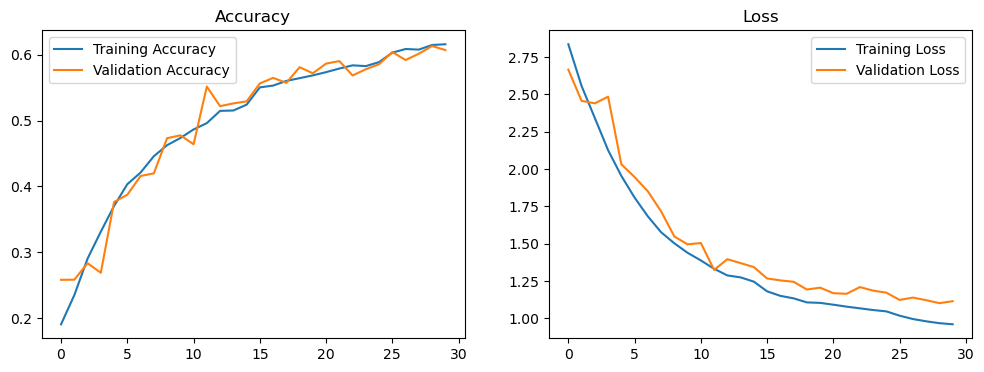

In [176]:
# plot training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 377ms/step


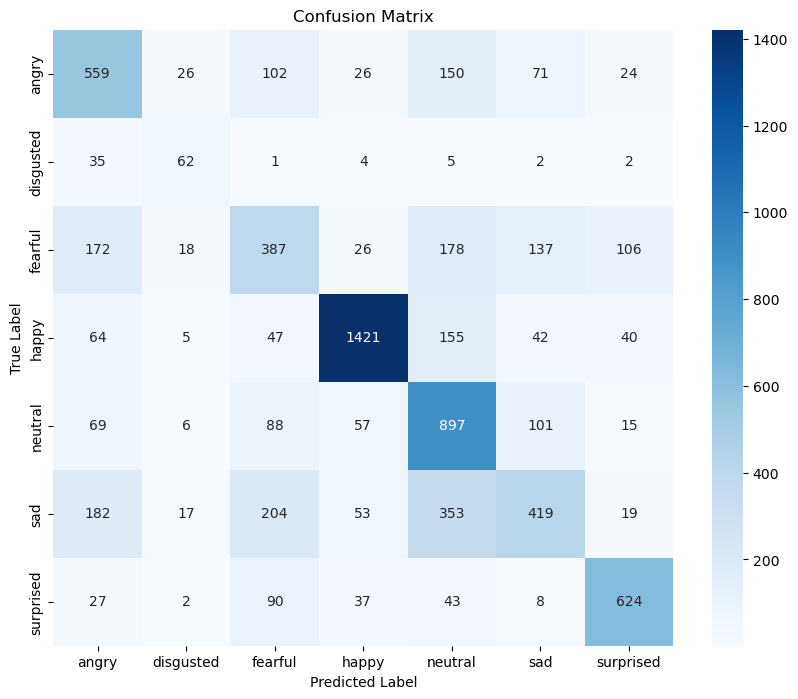

In [177]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# retrieve predicted values
y_pred_probs = model.predict(test_generator)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# extract class labels
y_true = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [178]:
from sklearn.metrics import classification_report

report = classification_report(test_generator.classes, y_pred, target_names=validation_generator.class_indices.keys())
print(report)


              precision    recall  f1-score   support

       angry       0.50      0.58      0.54       958
   disgusted       0.46      0.56      0.50       111
     fearful       0.42      0.38      0.40      1024
       happy       0.88      0.80      0.84      1774
     neutral       0.50      0.73      0.60      1233
         sad       0.54      0.34      0.41      1247
   surprised       0.75      0.75      0.75       831

    accuracy                           0.61      7178
   macro avg       0.58      0.59      0.58      7178
weighted avg       0.62      0.61      0.60      7178

